# Compare CASTEP al3x3 benchmark performance

This notebook compares the performance of the small al3x3 benchmark across different UK HPC facilities.

## Setup section

Import the required modules and define useful functions.

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from appanalysis import castep

## Setup data locations

### Cirrus

In [4]:
cirruscpn = 36
cirrusfiles = {1:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.1nodes',
                  2:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.2nodes',
                  4:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.4nodes',
                  8:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.8nodes',
                  16:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.16nodes'}

### Thomas

In [5]:
thomascpn = 24
thomasfiles = {1:'../al3x3/results/Thomas/al3x3.castep.1nodes',
               2:'../al3x3/results/Thomas/al3x3.castep.2nodes',
               4:'../al3x3/results/Thomas/al3x3.castep.4nodes',
               8:'../al3x3/results/Thomas/al3x3.castep.8nodes',
               16:'../al3x3/results/Thomas/al3x3.castep.16nodes'}

### Athena

In [6]:
athenacpn = 28
athenafiles = {1:'../al3x3/results/Athena/al3x3.castep.1nodes',
               2:'../al3x3/results/Athena/al3x3.castep.2nodes',
               4:'../al3x3/results/Athena/al3x3.castep.4nodes',
               8:'../al3x3/results/Athena/al3x3.castep.8nodes',
               16:'../al3x3/results/Athena/al3x3.castep.16nodes'}

### ARCHER

In [7]:
archercpn = 24
archerfiles = {1:'../al3x3/results/ARCHER/al3x3.castep.1nodes',
               2:'../al3x3/results/ARCHER/al3x3.castep.2nodes',
               4:'../al3x3/results/ARCHER/al3x3.castep.4nodes',
               8:'../al3x3/results/ARCHER/al3x3.castep.8nodes'}

### CSD3-Skylake

In [8]:
csd3scpn = 32
csd3sfiles = {1:'../al3x3/results/CSD3-Skylake/al3x3.castep.1nodes',
                2:'../al3x3/results/CSD3-Skylake/al3x3.castep.2nodes',
                4:'../al3x3/results/CSD3-Skylake/al3x3.castep.4nodes',
                8:'../al3x3/results/CSD3-Skylake/al3x3.castep.8nodes',
                16:'../al3x3/results/CSD3-Skylake/al3x3.castep.16nodes',}

## Process data

In [9]:
cirrusnodes, cirrusscf, cirrussu = castep.calcperf(cirrusfiles, cirruscpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              36           102.4            1.00
              2              72            50.0            2.05
              4             144            31.4            3.27
              8             288            20.3            5.04
             16             576            20.7            4.95


In [10]:
thomasnodes, thomasscf, thomassu = castep.calcperf(thomasfiles, thomascpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              24           123.3            1.00
              2              48            52.9            2.33
              4              96            30.0            4.12
              8             192            18.7            6.59
             16             384            17.3            7.12


In [11]:
athenanodes, athenascf, athenasu = castep.calcperf(athenafiles, athenacpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              28           100.6            1.00
              2              56            48.7            2.07
              4             112            40.1            2.51
              8             224            15.2            6.62
             16             448            18.8            5.35


In [12]:
archernodes, archerscf, archersu = castep.calcperf(archerfiles, archercpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              24           184.2            1.00
              2              48            88.2            2.09
              4              96            51.3            3.59
              8             192            33.2            5.55


In [13]:
csd3snodes, csd3sscf, csd3ssu = castep.calcperf(csd3sfiles, csd3scpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              32            61.3            1.00
              2              64            31.4            1.95
              4             128            19.7            3.10
              8             256            14.1            4.35
             16             512            10.5            5.81


## Performance Comparison

### Performance

Performance is 1/runtime and reveals the differences between architectures better than absolute runtime. In this case it yields SCF cycles per second.

This plot shows that performance for this benchmark is dominated by the on-node performance (processor/memory) as the more modern Xeon processors on the Tier-2 systems (CSD3-Skylake, Cirrus, Thomas, Athena) outperform the older Xeon processors on ARCHER; and the most modern processors (CSD3-Skylake) with the highest processor performance and memory bandwidth show the best performance.

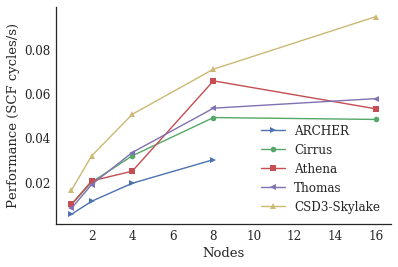

In [14]:
plt.plot(archernodes, [1/x for x in archerscf], '>-', label='ARCHER')
plt.plot(cirrusnodes, [1/x for x in cirrusscf], 'o-', label='Cirrus')
plt.plot(athenanodes, [1/x for x in athenascf], 's-', label='Athena')
plt.plot(thomasnodes, [1/x for x in thomasscf], '<-', label='Thomas')
plt.plot(csd3snodes, [1/x for x in csd3sscf], '^-', label='CSD3-Skylake')
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('castep_al3x3perf.png', dpi=300)

Highest absolute performance is on the CSD3-Skylake system. Broadwell system performance increases as the cores-per-node decreases: Thomas (24 core per node) is best. Why? Less cores gives more memory bandwidth per core and more interconnect bandwith per core. ARCHER has lowest absolute performance due to having oldest generation of processors.

## Single node performance comparisons

In [15]:
nperf = {}
cperf = {}
nperf['ARCHER'] = archerscf[0]
cperf['ARCHER'] = archerscf[0]/(archercpn)
nperf['Cirrus'] = cirrusscf[0]
cperf['Cirrus'] = cirrusscf[0]/(cirruscpn)
nperf['Thomas'] = thomasscf[0]
cperf['Thomas'] = thomasscf[0]/(thomascpn)
nperf['Athena'] = athenascf[0]
cperf['Athena'] = athenascf[0]/(athenacpn)
nperf['CSD3-Skylake'] = csd3sscf[0]
cperf['CSD3-Skylake'] = csd3sscf[0]/(csd3scpn)

print("Performance improvement relative to ARCHER:\n")
print("{:>15s} {:>15s} {:>15s}".format('System', 'Mean SCF (s)', 'Improvement'))
print("{:>15s} {:>15s} {:>15s}".format('======', '============', '==========='))
print("1-node (per node)")
for system in sorted(nperf):
    print("{:>15s} {:>15.3f} {:>15.3f}".format(system, nperf[system], nperf['ARCHER']/nperf[system]))

print("per-core")
for system in sorted(cperf):
    print("{:>15s} {:>15.3f} {:>15.3f}".format(system, cperf[system], cperf['ARCHER']/cperf[system]))

Performance improvement relative to ARCHER:

         System    Mean SCF (s)     Improvement
         ======    ============     ===========
1-node (per node)
         ARCHER         184.184           1.000
         Athena         100.600           1.831
   CSD3-Skylake          61.280           3.006
         Cirrus         102.421           1.798
         Thomas         123.312           1.494
per-core
         ARCHER           7.674           1.000
         Athena           3.593           2.136
   CSD3-Skylake           1.915           4.007
         Cirrus           2.845           2.697
         Thomas           5.138           1.494


Theoretical memory bandwidth ratios:

* E5v2:E5v4 = 1.0:1.3
* E5v2:Gold = 1.0:2.0
* E5v4:Gold = 1.0:1.6

Core counts:

* ARCHER: 24 cores, 2.7GHz
* Athena: 28 cores, 2.4GHz
* CSD3-Skylake: 32 cores, 2.6GHz
* Cirrus: 36 cores, 2.1GHz
* Thomas: 24 cores, 2.1GHz

Performance of this benchmark is a function of both memory bandwidth, architecture and core count (probably due to increased shared memory for all-to-all). For example, ARCHER and Thomas have same core counts but Thomas gets a bigger performance jump than memory bandwidth alone would suggest (even though the processors are slower). This suggests the architecture (FP unit, cache structure, DDR4 vs DDR3) are also having a positive effect. This is also seen in the Skylake performance which is 3x faster than ARCHER when memory bandwidth alone is only 2x better. We would still expect that memory bandwidth is a large part of this performance increase.